In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
import pandas as pd
from scipy.interpolate import interpn
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)

%matplotlib inline

In [2]:
# load calibration table into pandas (I like to use astropy for this!)
calibration_table = ascii.read('calibration_values_final.dat').to_pandas()

In [3]:
# let's see what the calibration table looks like!
calibration_table

Element  Source      C_ZP  MG_H  C_LOGG_0.25  C_LOGG_0.75  C_LOGG_1.25  \
0         O  ASPCAP -0.025233  -0.7     0.122413     0.110120     0.077184   
1         O  ASPCAP -0.025233  -0.6     0.077489     0.071658     0.062236   
2         O  ASPCAP -0.025233  -0.5     0.059866     0.044108     0.042094   
3         O  ASPCAP -0.025233  -0.4     0.043405     0.023815     0.029638   
4         O  ASPCAP -0.025233  -0.3     0.000877     0.003671     0.018772   
..      ...     ...       ...   ...          ...          ...          ...   
259      Ce  BAWLAS -0.270557   0.0     0.475912     0.475912     0.395491   
260      Ce  BAWLAS -0.270557   0.1     0.517316     0.517316     0.411855   
261      Ce  BAWLAS -0.270557   0.2     0.569010     0.569010     0.452310   
262      Ce  BAWLAS -0.270557   0.3     0.567933     0.567933     0.465626   
263      Ce  BAWLAS -0.270557   0.4     0.567933     0.567933     0.486645   

     C_LOGG_1.75  C_LOGG_2.25  C_LOGG_2.75  C_LOGG_3.25  C_LOGG_RC  
0       0.008790    -0.078782    -0.081200    -0.081200  -0.057636  
1       0.008790    -0.069021    -0.090320    -0.090320  -0.057636  
2       0.008790    -0.059546    -0.074037    -0.061900  -0.057785  
3       0.008790    -0.036640    -0.050375    -0.055643  -0.033883  
4       0.008790    -0.020035    -0.022795    -0.032122  -0.019297  
..           ...          ...          ...          ...        ...  
259     0.360345     0.333374     0.322095     0.332321   0.327706  
260     0.360345     0.334116     0.323325     0.322559   0.325892  
261     0.360345     0.326639     0.329709     0.326591   0.332544  
262     0.360345     0.332176     0.304676     0.315799   0.301838  
263     0.360345     0.317754     0.319478     0.327736   0.302264  

[264 rows x 12 columns]

In [4]:
# set up element arrays
calib_elems = pd.unique(np.array([calibration_table['Element'][i]+'_'+calibration_table['Source'][i] for i in range(len(calibration_table))]))
all_elems = np.insert(calib_elems, 0, 'Mg_ASPCAP')

# set up arrays for [Mg/H] and logg bins
MgH_bin_centers = np.unique(calibration_table['MG_H'])
logg_bin_centers = np.linspace(0.25, 3.75, 7, endpoint=False)

logg_col_names = ['C_LOGG_0.25', 'C_LOGG_0.75', 'C_LOGG_1.25', 'C_LOGG_1.75','C_LOGG_2.25', 'C_LOGG_2.75','C_LOGG_3.25']

### Reproduce Sit et al. Figure 3
The position of Cu and Ce are switched in the paper to match the later median residual plots (where Cu, as a BAWLAS-only element, was frequently not measured and thus placed at the end of the sequence), but the order here groups all Fe-peak elements by atomic number and places the s-process element Ce at the end.

Text(0.5, 0.08, '$\\log(g)$')

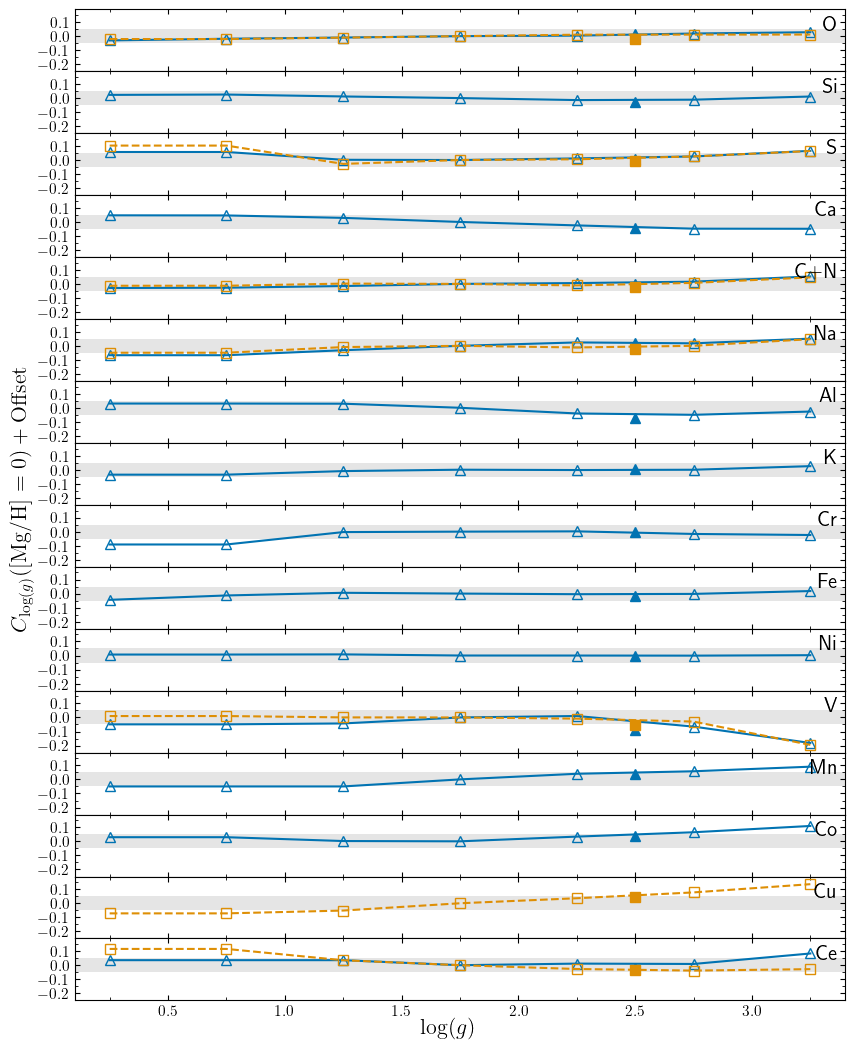

In [5]:
fig, axs = plt.subplots(16, 1, sharex=True, sharey=True, figsize=(8.5*1.17,11*1.17))

mgh_bin = 0
i = 0
all_ele = pd.unique(np.array([elem.split('_')[0] for elem in calib_elems]))
for ele in all_ele:
    ele_aspcap = calibration_table[(calibration_table['MG_H']==mgh_bin) & (calibration_table['Element']==ele) & (calibration_table['Source']=='ASPCAP')]
    ele_bawlas = calibration_table[(calibration_table['MG_H']==mgh_bin) & (calibration_table['Element']==ele) & (calibration_table['Source']=='BAWLAS')]
    if len(ele_aspcap)>0:
        logg_zp_aspcap = ele_aspcap['C_LOGG_1.75'].iloc[0]
        p1 = axs[i].plot(logg_bin_centers, ele_aspcap[logg_col_names].values.flatten() - logg_zp_aspcap, c='#0173b2', marker='^', mfc='none', ms=7)
        axs[i].plot(2.5, ele_aspcap['C_LOGG_RC'].iloc[0] - logg_zp_aspcap, marker='^', ms=7, c=p1[0].get_color())
    if len(ele_bawlas)>0:
        logg_zp_bawlas = ele_bawlas['C_LOGG_1.75'].iloc[0]
        p2 = axs[i].plot(logg_bin_centers, ele_bawlas[logg_col_names].values.flatten() - logg_zp_bawlas, ls='--', c='#de8f05', marker='s', mfc='none', ms=7)
        axs[i].plot(2.5, ele_bawlas['C_LOGG_RC'].iloc[0] - logg_zp_bawlas, marker='s', ms=7, c=p2[0].get_color())
    axs[i].text(0.99, 0.9, ele, ha='right', va='top', fontsize=15, transform=axs[i].transAxes)
    i += 1

axs[0].set_xlim(0.1,3.4)
axs[0].set_ylim(-0.25,0.19)
for ax in axs:
    ax.axhspan(-0.05, 0.05, facecolor='gray', alpha=0.2)
    ax.xaxis.set_minor_locator(MultipleLocator(0.25))
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.tick_params(axis='y', which='both', direction='in', right=True, labelsize=11)
    ax.tick_params(axis='x', which='both', direction='in', top=True, labelsize=11)
    
fig.subplots_adjust(hspace=0)
fig.supylabel(r'$C_{\log(g)}(\mathrm{[Mg/H]}=0) + \mathrm{Offset}$', fontsize=16, x=0.06)
fig.supxlabel(r'$\log(g)$', fontsize=16, y=0.08)

### Apply $C_{\log(g)}$ and $C_{ZP}$ to raw abundances
We'll use the first 10 entries in the residual abundance catalog to demonstrate, but this can be extended to any number of stars. The APOGEE DR17 red clump catalog can be accessed at https://www.sdss4.org/dr17/data_access/value-added-catalogs/?vac_id=apogee-red-clump-(rc)-catalog

In [6]:
# load residual abundance catalog data
with fits.open('2process_residual_abund_catalog_final.fits') as hdul:
    catalog_data = hdul[1].data

# get red clump stars
with fits.open('apogee-rc-DR17.fits') as rc_hdul: # adjust file path as needed
    rc_ids = rc_hdul[1].data['APOGEE_ID']
rc_mask = np.isin(catalog_data['APOGEE_ID'], list(rc_ids))

# make an array of raw abundances for the first 10 stars in the residual abundance catalog
nstars = 10
xh_arr = np.empty((len(all_elems), nstars))
for i, elem in enumerate(all_elems):
    elem = elem.upper()
    ele, source = elem.split('_')
    xh_arr[i,:] = catalog_data[ele+'_H_'+source+'_RAW'][:nstars]

In [7]:
# in this cell define some functions to get the correct logg calibrations and apply them
def extract_logg_grid_for_elem(ele, source, rc=False):
    """
    Input
    -----
    ele : str
          Element symbol matching entries in calibration_table (e.g., "O" or "Ca")
    source : str
             Element source matching entries in calibration_table (e.g., "ASPCAP" or "BAWLAS")
    rc : bool
         True = extract red clump calibrations
    
    Output
    ------
    grid : ndarray (dtype=float)
           Array of log(g) calibration values for a given element.
           2D array for non-RC, 1D array for RC
    """
    if rc==True:
        grid = calibration_table[(calibration_table['Element']==ele) & (calibration_table['Source']==source)]['C_LOGG_RC'].values
    elif rc==False:
        grid = calibration_table[(calibration_table['Element']==ele) & (calibration_table['Source']==source)][logg_col_names].values
    return grid

def apply_logg_offsets_to_star(mgh, logg, xh_vals, rc):
    """
    Input
    -----
    mgh : float
          [Mg/H] of star
    logg : float
           log(g) of star
    xh_vals : ndarray (dtype=float)
              1D array of [X/H] values. [Mg/H] must be the first element in the array.
    rc : bool
         Red clump membership (True = RC, False = Not RC)
    
    Output
    ------
    corr_xh : ndarray (dtype=float)
              1D array of log(g)-calibrated [X/H] values, 
              in the order of xh_vals
    """
    star_offsets = np.zeros_like(xh_vals)
    for i, elem in enumerate(calib_elems):
        ele, source = elem.split('_')
        if rc==True:
            offsets = extract_logg_grid_for_elem(ele, source, rc=True)
            star_offsets[i+1] = np.interp(mgh, MgH_bin_centers, offsets)

        elif rc==False:
            offsets = extract_logg_grid_for_elem(ele, source)
            grid = (MgH_bin_centers, logg_bin_centers)
            interp_point = np.array([mgh, logg])
            star_offsets[i+1] = interpn(grid, offsets, interp_point, bounds_error=False, fill_value=None)
            
    corr_xh = xh_vals + star_offsets
    
    return corr_xh

In [8]:
# now actually apply the logg calibrations to our sample of stars
corr_xh_arr = np.empty((len(all_elems), nstars))
for i in range(nstars):
    corr_xh_arr[:,i] = apply_logg_offsets_to_star(xh_arr[0,i], catalog_data['LOGG'][i], xh_arr[:,i], rc_mask[i])
    
# make [X/Mg] array (first column of xh_arr is [Mg/H])
corr_xmg_arr = corr_xh_arr - xh_arr[0]

While the $\log(g)$ calibrations are derived for \[X/H\], the zeropoint offsets are derived for \[X/Mg\] since they force \[X/Mg\] = 0 at \[Mg/H\] = 0. If you are only looking to correct the $\log(g)$ systematics and do not need the overall zeropoint, no need to run the next cell.

In [9]:
# apply zeropoint offsets to [X/Mg] values
for j, elem in enumerate(calib_elems):
    ele, source = elem.split('_')
    zp = pd.unique(calibration_table[(calibration_table['Element']==ele) & (calibration_table['Source']==source)]['C_ZP'])[0]
    corr_xmg_arr[j+1] = corr_xmg_arr[j+1] + zp

# convert ZP-corrected [X/Mg] to [X/H]
corr_xh_arr = corr_xmg_arr + xh_arr[0]

Each row in the final `corr_xh_arr` array (matching the order of `all_elems`) should match the corresponding `_ADJ` column for that element in the catalog table (up to the occasional floating-point rounding error, which I have occasionally found, but which are too small to meaningfully affect any abundance analyses).